# Greenhouse Model

## Import dependencies and data

In [1]:
# import dependencies
import os
import pickle
import json
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

In [31]:
from data_funcs import k_fold_data, k_fold_data_validation

## Create data for specific fold

In [7]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'

In [8]:
# get merged data
data = pd.read_csv(
    data_path + 'data_processed.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

In [47]:
k_idx = 19
k_frac = 0.05
m = 5
t_steps = 1
n_steps = 12

# Define cols to use
cols = [
    ('temperatures', 'TA01_GT10X_GM10X'),
    #('temperatures', 'TA01_GT401_GM401_scaled'),
    #('temperatures', 'DC_GT301_damped_scaled'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('sun', 'gsi'),
    ('power', 'phase'),
    ('time', 'minofday'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output')
]

# get data
train_tup, test_tup, _, col_params = k_fold_data_validation(
    data=data, 
    k_idx=k_idx, 
    k_frac=k_frac, 
    m=m, 
    cols=cols, 
    t_steps=t_steps, 
    n_steps=n_steps,
    setpoint=True,
    shuffle=False
)

# extract from tuples
(sequences_train, targets_train, temps_train, temps_t_train, _) = train_tup
(sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, _) = test_tup

# # reshape training matrix
# temps_train = temps_t_train[:, np.newaxis]
# targets_train = targets_train[:, np.newaxis]

# # reshape testing matrix
# temps_test = temps_t_test[:, np.newaxis]
# targets_test = targets_test[:, np.newaxis]

a


In [48]:
sequences_train = sequences_train[:, -2, :]
sequences_test = sequences_test[:, -2, :]
sequences_masked = sequences_masked[:, -2, :]

## Def model funcs

In [56]:
from networks import feedForwardNeuralNetwork
from opts import RMSProp, AdaGrad, Adam

In [57]:
# hyperparams
units = 32
k1 = 7
k2 = 1
T = 6
lambd = 0.0
sigma = 1.0

seed = 1
optimizer = None

In [58]:
model = feedForwardNeuralNetwork(
    k1=k1,
    k2=k2,
    m=[32, 16, 8],
    seed=seed
)

adagrad = AdaGrad(
    eps=1e-12,
    weights=model.weights
)

rms_prop = RMSProp(
    beta=0.9,
    eps=1e-12,
    weights=model.weights
)

adam = Adam(
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    weights=model.weights,
)

In [59]:
# model.optimizer = None
model.optimizer = adam
# model.optimizer = adagrad
# model.optimizer = rms_prop

In [60]:
num_weights = 0
for _, weight in model.weights.items():
    num_weights += weight.size

In [61]:
num_weights

929

## Run training w. SGD

In [62]:
n_batch = 32
lr = 0.001
n_epochs = 50

# init time step
t = 0

loss_hist = []

# create list of idxs for shuffling
idxs = list(range(len(sequences_train)))
for epoch in range(1, n_epochs):
    np.random.shuffle(idxs)
    sequences_train, temps_train, targets_train = sequences_train[idxs], temps_train[idxs], targets_train[idxs]
    
    for i in range(len(sequences_train) // n_batch):
        Xt_train_batch = sequences_train[i*n_batch:(i+1)*n_batch]
        Xc_train_batch = temps_train[i*n_batch:(i+1)*n_batch]
        Y_train_batch = targets_train[i*n_batch:(i+1)*n_batch]
            
        model.train(
            X_t=Xt_train_batch,
            X_c=Xc_train_batch,
            Y=Y_train_batch,
            sigma=sigma,
            lambd=lambd,
            eta=lr,
            t=epoch
        )
        
        #if t % 200 == 0:
        #    loss = model.compute_loss(X_t=sequences_train, X_c=temps_train, Y=targets_train, lambd=lambd)
        #    loss_hist.append(loss)
        #    
        #    print(epoch, t, loss)
        #    
        #t += 1
    loss = model.compute_loss(X_t=sequences_train, X_c=temps_train, Y=targets_train, lambd=lambd)
    loss_hist.append(loss)
    print(epoch, loss)

1 0.12713192749205016
2 0.12840158829629325
3 0.12831124836977573
4 0.12687415107573569
5 0.12592999984904796
6 0.1257009773274451
7 0.12419602284366715
8 0.1231444545880355
9 0.12298777300224266
10 0.12311494679269812
11 0.12091793842977486
12 0.12017203213886735
13 0.11961852006771234
14 0.1194674150369104
15 0.11890509391294829
16 0.11803473124860261
17 0.11766926382884646
18 0.1170680427562193
19 0.11664723174244158
20 0.11732033277219216
21 0.11658986468001122
22 0.11638360408378562
23 0.11515039047089579
24 0.11626892594384051
25 0.11492982482575
26 0.1148479152992605
27 0.11538784898252677
28 0.11417223442154055
29 0.11345807289358766
30 0.11738881368129003
31 0.11403126401211676
32 0.11524371156170912
33 0.11308075955389052
34 0.11446399049151584
35 0.11258700177330187
36 0.11280693004541563
37 0.11580820623975896
38 0.11247891577239101
39 0.11343208618800804
40 0.11178180262300046
41 0.11114669608609187
42 0.11144943228368136
43 0.1130007033398048
44 0.11057781398706762
45 0.1

In [63]:
rnn_preds_simple = []
rnn_encodings_simple = []

pred_queue = deque(maxlen=t_steps)
for temp in temps_test[:t_steps]:
    pred_queue.append(temp[np.newaxis, :])
    rnn_preds_simple.append(temp)
    
for seq in sequences_masked:
    temp = pred_queue.popleft()
    temp_pred, _ = model.predict(X_t=seq[np.newaxis, :], X_c=temp, train=False)
    pred_queue.append(temp_pred)
    rnn_preds_simple.append(temp_pred[0])
#     rnn_encodings_simple.append(encoded[0])
    
#y_hat, encoded = model.predict(sequences_test, temps_test, train=False)

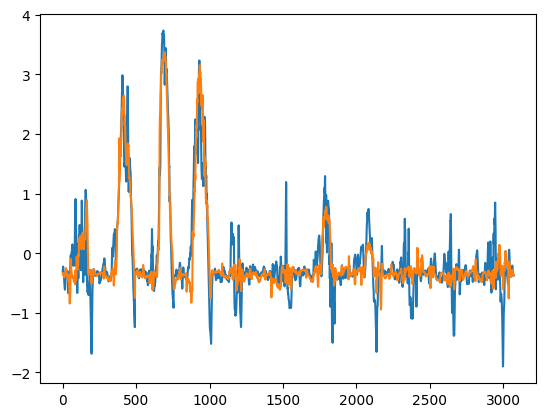

In [66]:
plt.plot(targets_test)#[-1500:])
plt.plot(rnn_preds_simple)#[-1500:])
#plt.ylim(-10, 10)